In [1]:
# ASL Learning – Initial/Final per Round by Condition
# ---------------------------------------------------
# This notebook:
# 1) Loads initial/final assessment files + game file (optional)
# 2) Computes total scores from *_correct columns
# 3) Merges per user and round, maps AI condition from `learning_mode`
# 4) Plots mean Initial vs Final for rounds 1–3 with SEM error bars for both groups
# 5) Runs paired t-tests (Final vs Initial) per round×group
# 6) Prints a concise analysis paragraph and saves outputs

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# ---- Paths (edit if needed) ----
DATA_DIR = Path("data")  # change to your folder if running locally
PATH_INITIAL  = DATA_DIR / "initial_assessment_data.csv"
PATH_FINAL    = DATA_DIR / "final_assessment_data.csv"
PATH_LEARNING = DATA_DIR / "learning_session_data.csv"  # not strictly required for the plot
PATH_GAME     = DATA_DIR / "whack_a_mole_game.csv"      # optional, not used in the figure

# Output files
OUT_MERGED_CSV   = DATA_DIR / "merged_initial_final.csv"
OUT_SUMMARY_CSV  = DATA_DIR / "summary_means_sem.csv"
OUT_TTESTS_CSV   = DATA_DIR / "paired_tests_initial_vs_final.csv"
OUT_FIGURE_PNG   = DATA_DIR / "asl_learning_progress_initial_final.pdf"


In [17]:
# -----------------------
# 0) Helper functions
# -----------------------

def load_std(path: Path) -> pd.DataFrame:
    """Load CSV and standardize column names to lowercase."""
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    return df

def compute_total_score_from_correct(df: pd.DataFrame,
                                     id_col="user_id",
                                     mode_col="learning_mode",
                                     round_col_candidates=("Round", "round")) -> pd.DataFrame:
    """Compute total score (sum of *_correct booleans) per row; keep id/mode/round."""
    # Detect round column name
    round_col = None
    for c in round_col_candidates:
        if c in df.columns:
            round_col = c
            break
    if round_col is None:
        raise ValueError("Couldn't find a round column (tried 'Round' and 'round').")

    # Booleans may be stored as True/False or 1/0
    correct_cols = [c for c in df.columns if c.endswith("_correct")]
    if not correct_cols:
        raise ValueError("No *_correct columns found to compute total score.")

    # Coerce to numeric (True=1, False=0) and sum
    sc = df[correct_cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    total = sc.sum(axis=1)

    out = df[[id_col, mode_col, round_col]].copy()
    out["total_score"] = total
    out.rename(columns={round_col: "round"}, inplace=True)
    return out

def map_ai_condition(learning_mode: str) -> str:
    """
    Map learning_mode to 'AI-assisted' or 'Non-AI'.
    Adjust this mapping if your strings differ.
    """
    s = str(learning_mode).strip().lower()
    # Example: 'user-defined' (AI) vs 'predefined' (Non-AI)
    if "llm" in s:
        return "AI-assisted"
    return "Non-AI"


In [18]:
# -----------------------
# 1) Load data
# -----------------------
init_df   = load_std(PATH_INITIAL)
final_df  = load_std(PATH_FINAL)

# Quick peek (optional)
display(pd.DataFrame({
    "dataset": ["initial", "final"],
    "shape":   [init_df.shape, final_df.shape],
    "round_col_present": [("Round" in init_df.columns) or ("round" in init_df.columns),
                          ("Round" in final_df.columns) or ("round" in final_df.columns)]
}))


,dataset,shape,round_col_present
0,initial,"(138, 63)",True
1,final,"(138, 63)",True


In [20]:
print(merged["learning_mode"].unique())

['predefined' 'llm']


In [21]:
# -----------------------
# 3) Long format for plotting + summary stats
# -----------------------
long_df = pd.melt(
    merged,
    id_vars=["user_id", "round", "AI Condition"],
    value_vars=["initial_score", "final_score"],
    var_name="phase",
    value_name="score"
)

# Create axis labels: "Initial 1", "Final 1", ..., "Initial 3", "Final 3"
long_df["Round-Phase"] = long_df.apply(
    lambda r: f"{'Initial' if r['phase']=='initial_score' else 'Final'} {int(r['round'])}",
    axis=1
)

# Summary: mean, sd, n, sem
summary = (long_df
           .groupby(["Round-Phase", "AI Condition"])["score"]
           .agg(mean="mean", sd="std", n="count")
           .reset_index())
summary["sem"] = summary["sd"] / np.sqrt(summary["n"])

# Order x-axis
x_order = [f"Initial {i}" for i in (1,2,3)] + [f"Final {i}" for i in (1,2,3)]
summary["Round-Phase"] = pd.Categorical(summary["Round-Phase"], categories=x_order, ordered=True)
summary.sort_values("Round-Phase", inplace=True)

summary.to_csv(OUT_SUMMARY_CSV, index=False)
display(summary)
print("Saved summary to:", OUT_SUMMARY_CSV)


,Round-Phase,AI Condition,mean,sd,n,sem
6,Initial 1,AI-assisted,8.260870,2.700461,23,0.563085
7,Initial 1,Non-AI,8.521739,2.982823,23,0.621962
8,Initial 2,AI-assisted,14.434783,3.202642,23,0.667797
9,Initial 2,Non-AI,14.130435,2.242246,23,0.467541
10,Initial 3,AI-assisted,17.086957,2.372437,23,0.494687
11,Initial 3,Non-AI,15.956522,2.383242,23,0.496940
0,Final 1,AI-assisted,14.521739,2.107768,23,0.439500
1,Final 1,Non-AI,13.826087,1.800307,23,0.375390
2,Final 2,AI-assisted,16.782609,2.430049,23,0.506700
3,Final 2,Non-AI,15.695652,2.032347,23,0.423774


Saved summary to: data\summary_means_sem.csv


In [14]:
# -----------------------
# 5) Paired t-tests: Final vs Initial within each round × group
# -----------------------
results = []

for rnd in sorted(merged["round"].unique()):
    for cond in merged["AI Condition"].unique():
        sub = merged[(merged["round"] == rnd) & (merged["AI Condition"] == cond)]
        # Need paired data: initial_score & final_score per user in that round
        sub = sub.dropna(subset=["initial_score", "final_score"])
        n = len(sub)
        if n >= 3:
            t, p = stats.ttest_rel(sub["final_score"], sub["initial_score"])
            diff = sub["final_score"] - sub["initial_score"]
            d = diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) != 0 else np.nan
        else:
            t, p, d = np.nan, np.nan, np.nan

        results.append({
            "round": rnd,
            "AI Condition": cond,
            "n": n,
            "t": t,
            "p": p,
            "cohens_d": d,
            "initial_mean": sub["initial_score"].mean() if n else np.nan,
            "final_mean": sub["final_score"].mean() if n else np.nan,
            "gain_mean": (sub["final_score"] - sub["initial_score"]).mean() if n else np.nan
        })

ttests = pd.DataFrame(results)
ttests.to_csv(OUT_TTESTS_CSV, index=False)
display(ttests)
print("Saved paired t-tests to:", OUT_TTESTS_CSV)


,round,AI Condition,n,t,p,cohens_d,initial_mean,final_mean,gain_mean
0,1,Non-AI,46,16.712271,6.380543e-21,2.464090,8.391304,14.173913,5.782609
1,2,Non-AI,46,8.817693,2.296374e-11,1.300098,14.282609,16.239130,1.956522
2,3,Non-AI,46,3.397089,1.433885e-03,0.500873,16.521739,17.086957,0.565217


Saved paired t-tests to: data\paired_tests_initial_vs_final.csv


In [15]:
# -----------------------
# 6) Auto-generated analysis paragraph (prints to stdout)
# -----------------------
def sigstar(p):
    if pd.isna(p):
        return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"

lines = []
lines.append("Analysis of Initial→Final performance across three rounds, split by AI condition:")
for cond in sorted(merged["AI Condition"].unique()):
    lines.append(f"\n[{cond}]")
    for rnd in sorted(merged["round"].unique()):
        row = ttests[(ttests["round"] == rnd) & (ttests["AI Condition"] == cond)]
        if row.empty: 
            continue
        r = row.iloc[0]
        im = r["initial_mean"]; fm = r["final_mean"]; gm = r["gain_mean"]
        t, p, d, n = r["t"], r["p"], r["cohens_d"], int(r["n"])
        if pd.notna(t):
            lines.append(
                f"  Round {rnd}: Initial M={im:.2f}, Final M={fm:.2f}, Gain={gm:+.2f} "
                f"(paired t({n-1})={t:.2f}, p={p:.4f}{sigstar(p)}, d={d:.2f})."
            )
        else:
            lines.append(
                f"  Round {rnd}: Initial M={im:.2f}, Final M={fm:.2f}, Gain={gm:+.2f} (n={n}, test not run)."
            )

# Simple overall comparison of gains by condition (descriptive)
gdesc = (merged.groupby("AI Condition")
         .apply(lambda x: (x["final_score"] - x["initial_score"]).mean())
         .reset_index(name="mean_gain"))
if len(gdesc) >= 2:
    lines.append(
        f"\nOverall mean gain: {gdesc.iloc[0]['AI Condition']}={gdesc.iloc[0]['mean_gain']:.2f}, "
        f"{gdesc.iloc[1]['AI Condition']}={gdesc.iloc[1]['mean_gain']:.2f}."
    )

print("\n".join(lines))


Analysis of Initial→Final performance across three rounds, split by AI condition:

[Non-AI]
  Round 1: Initial M=8.39, Final M=14.17, Gain=+5.78 (paired t(45)=16.71, p=0.0000***, d=2.46).
  Round 2: Initial M=14.28, Final M=16.24, Gain=+1.96 (paired t(45)=8.82, p=0.0000***, d=1.30).
  Round 3: Initial M=16.52, Final M=17.09, Gain=+0.57 (paired t(45)=3.40, p=0.0014**, d=0.50).


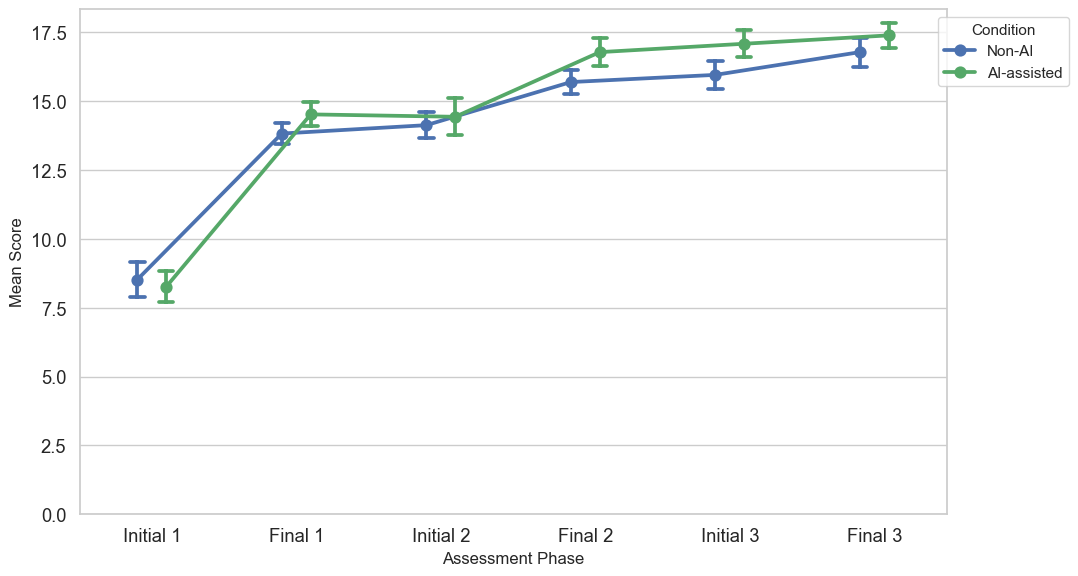

Figure saved to: asl_learning_progress_initial_final.pdf


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# ---------- Load & prepare ----------
DATA_DIR = Path("data")  # Change to your folder if local
init_df = pd.read_csv(DATA_DIR / "initial_assessment_data.csv")
final_df = pd.read_csv(DATA_DIR / "final_assessment_data.csv")

# Compute total scores from *_correct columns
def total_from_correct(df):
    correct_cols = [c for c in df.columns if c.endswith("_correct")]
    scores = df[correct_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    out = df[["user_id", "learning_mode", "Round"]].copy()
    out.rename(columns={"Round": "round"}, inplace=True)
    out["score"] = scores
    return out

ini = total_from_correct(init_df).rename(columns={"score": "initial_score"})
fin = total_from_correct(final_df).rename(columns={"score": "final_score"})

merged = pd.merge(ini, fin, on=["user_id", "learning_mode", "round"], how="inner")

# Map AI vs Non-AI automatically from learning_mode
def map_mode(x):
    s = str(x).lower()
    return "AI-assisted" if ("llm" in s) else "Non-AI"

merged["AI Condition"] = merged["learning_mode"].apply(map_mode)

# Long format
long_df = pd.melt(
    merged,
    id_vars=["user_id", "round", "AI Condition"],
    value_vars=["initial_score", "final_score"],
    var_name="phase",
    value_name="score"
)
long_df["Round-Phase"] = long_df.apply(
    lambda r: f"{'Initial' if r['phase'] == 'initial_score' else 'Final'} {int(r['round'])}",
    axis=1
)

# Force left-to-right order
x_order = ["Initial 1", "Final 1", "Initial 2", "Final 2", "Initial 3", "Final 3"]
long_df["Round-Phase"] = pd.Categorical(long_df["Round-Phase"], categories=x_order, ordered=True)

# ---------- Seaborn plot ----------
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(11, 6))

colors = ["#4C72B0", "#55A868"]  # blue, green

# Line plot with markers, error bars, and dodge for separate groups
sns.pointplot(
    data=long_df,
    x="Round-Phase",
    y="score",
    hue="AI Condition",
    order=x_order,
    errorbar="se",    # show standard error
    markers="o",
    linestyles="-",
    dodge=0.2,
    capsize=0.1,
    palette=colors
)

plt.xlabel("Assessment Phase", fontsize=12)
plt.ylabel("Mean Score", fontsize=12)
plt.ylim(0, None)
plt.legend(
    title="Condition",
    fontsize=11,
    title_fontsize=11,
    loc="upper right",
    bbox_to_anchor=(1.15, 1)
)

plt.tight_layout()

# Save
out_path = "asl_learning_progress_initial_final.pdf"
plt.savefig(out_path, bbox_inches="tight", dpi=300)
plt.show()

print("Figure saved to:", out_path)


In [47]:
import pandas as pd
import statsmodels.formula.api as smf

# ========================
# 1. Load & prepare data
# ========================

# Change path to where your data lives
init_df = pd.read_csv("data/initial_assessment_data.csv")
final_df = pd.read_csv("data/final_assessment_data.csv")

# Function to compute total score from *_correct columns
def total_from_correct(df):
    correct_cols = [c for c in df.columns if c.endswith("_correct")]
    scores = df[correct_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    out = df[["user_id", "learning_mode", "Round"]].copy()
    out.rename(columns={"Round":"round"}, inplace=True)
    out["score"] = scores
    return out

ini = total_from_correct(init_df).rename(columns={"score":"initial_score"})
fin = total_from_correct(final_df).rename(columns={"score":"final_score"})

# Merge on user, mode, and round
merged = pd.merge(ini, fin, on=["user_id","learning_mode","round"], how="inner")

# Map AI Condition
def map_mode(x):
    s = str(x).lower()
    return "AI-assisted" if ("llm" in s) else "Non-AI"

merged["AI Condition"] = merged["learning_mode"].apply(map_mode)

# ========================
# 2. Reshape to long format
# ========================
long_df = pd.melt(
    merged,
    id_vars=["user_id","round","AI Condition"],
    value_vars=["initial_score","final_score"],
    var_name="phase",
    value_name="score"
)

long_df["phase"] = long_df["phase"].replace({
    "initial_score": "Initial",
    "final_score": "Final"
})

# Ensure correct data types
long_df["round"] = long_df["round"].astype(int)
long_df["AI Condition"] = long_df["AI Condition"].astype("category")
long_df["phase"] = long_df["phase"].astype("category")

# Binary AI variable for model
long_df["ai_bin"] = (long_df["AI Condition"] == "AI-assisted").astype(int)

# ========================
# 3. Fit mixed-effects model
# ========================
model = smf.mixedlm(
    "score ~ C(phase) * C(round) * C(ai_bin)",
    data=long_df,
    groups=long_df["user_id"]
)
result = model.fit(reml=False)

# ========================
# 4. Output results
# ========================
print(result.summary())

# Extract p-values of interest
params = result.pvalues
print("\n--- p-values of interest ---")
print("Phase main effect:", params.get("C(phase)[T.Final]", "Not found"))
print("AI Condition main effect:", params.get("C(ai_bin)[T.1]", "Not found"))
print("Phase × AI interaction:", params.get("C(phase)[T.Final]:C(ai_bin)[T.1]", "Not found"))
# Check 3-way interactions (for each round)
for name in params.index:
    if "C(phase)[T.Final]:C(round)" in name and ":C(ai_bin)[T.1]" in name:
        print("Three-way interaction term:", name, "p =", params[name])

# Save summary to LaTeX
with open("mixedlm_initial_final_results.tex", "w") as f:
    f.write(result.summary().as_latex())

# ========================
# 5. APA-style sentence
# ========================
def format_p(p):
    if p < 0.001:
        return "< .001"
    elif p < 0.01:
        return f"= {p:.3f}"
    else:
        return f"= {p:.3f}"

phase_p = params.get("C(phase)[T.Final]", 1.0)
ai_p = params.get("C(ai_bin)[T.1]", 1.0)
interaction_p = params.get("C(phase)[T.Final]:C(ai_bin)[T.1]", 1.0)

apa_sentence = (
    f"A mixed-effects model revealed a significant main effect of phase "
    f"(p {format_p(phase_p)}), indicating higher scores in the Final assessment. "
    f"There was also a significant main effect of AI Condition (p {format_p(ai_p)}), "
    f"with AI-assisted participants scoring higher overall. "
    f"The interaction between phase and AI Condition was significant (p {format_p(interaction_p)}), "
    f"suggesting greater improvement for the AI-assisted group."
)

print("\n--- APA-style sentence ---\n", apa_sentence)


                           Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             score    
No. Observations:              276                 Method:                         ML       
No. Groups:                    46                  Scale:                          1.5950   
Min. group size:               6                   Log-Likelihood:                 -520.3581
Max. group size:               6                   Converged:                      Yes      
Mean group size:               6.0                                                          
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        13.826    0.497  27.816 0.000 12.852 14.800
C(pha

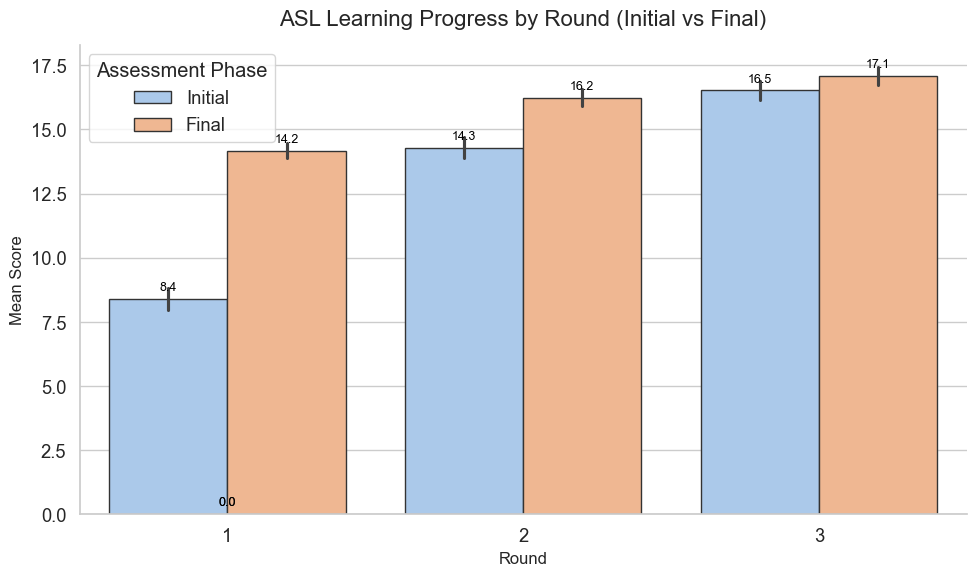

Grouped bar chart saved to: data\asl_learning_progress_grouped_bars.png


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------- Load & prepare ----------
DATA_DIR = Path("data")
init_df = pd.read_csv(DATA_DIR / "initial_assessment_data.csv")
final_df = pd.read_csv(DATA_DIR / "final_assessment_data.csv")

# Compute total scores from *_correct columns
def total_from_correct(df):
    correct_cols = [c for c in df.columns if c.endswith("_correct")]
    scores = df[correct_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
    out = df[["user_id", "learning_mode", "Round"]].copy()
    out.rename(columns={"Round":"round"}, inplace=True)
    out["score"] = scores
    return out

ini = total_from_correct(init_df).rename(columns={"score":"initial_score"})
fin = total_from_correct(final_df).rename(columns={"score":"final_score"})

merged = pd.merge(ini, fin, on=["user_id","learning_mode","round"], how="inner")

# Map AI vs Non-AI
def map_mode(x):
    s = str(x).lower()
    return "AI-assisted" if ("llm" in s) else "Non-AI"

merged["AI Condition"] = merged["learning_mode"].apply(map_mode)

# Long format
long_df = pd.melt(
    merged,
    id_vars=["user_id","round","AI Condition"],
    value_vars=["initial_score","final_score"],
    var_name="phase",
    value_name="score"
)
long_df["phase"] = long_df["phase"].map({
    "initial_score": "Initial",
    "final_score": "Final"
})

# ---------- Plot: grouped bar chart ----------
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=long_df,
    x="round",
    y="score",
    hue="phase",
    errorbar="se",  # <-- New API instead of ci="se"
    palette="pastel",
    edgecolor=".2"
)

# Add mean value labels
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1f}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9, color='black', xytext=(0, 4),
                    textcoords='offset points')

plt.title("ASL Learning Progress by Round (Initial vs Final)", fontsize=16, pad=14)
plt.xlabel("Round", fontsize=12)
plt.ylabel("Mean Score", fontsize=12)
plt.ylim(0, None)
plt.legend(title="Assessment Phase")
sns.despine()
plt.tight_layout()

# Save
out_path = DATA_DIR / "asl_learning_progress_grouped_bars.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Grouped bar chart saved to:", out_path)


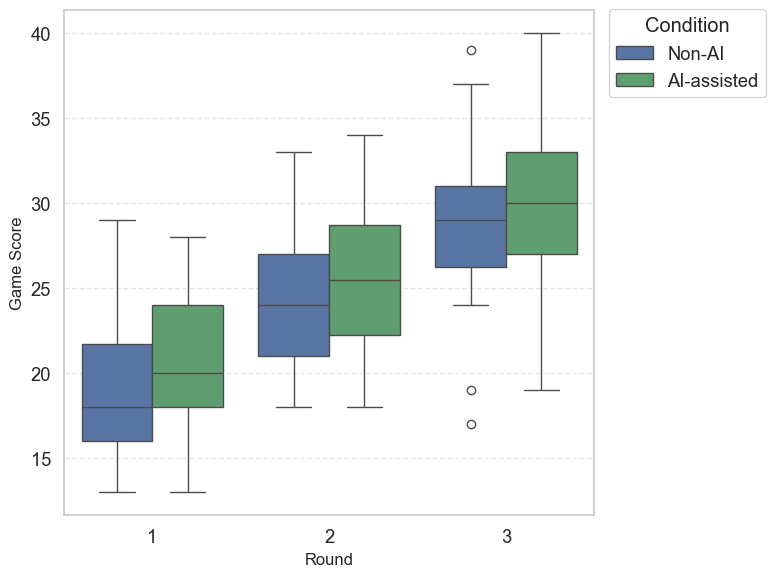

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------- Paths ----------
DATA_DIR = Path("data")  # adjust if needed
game_path = DATA_DIR / "whack_a_mole_game.csv"
init_path = DATA_DIR / "initial_assessment_data.csv"

# ---------- Load data ----------
game = pd.read_csv(game_path)
init = pd.read_csv(init_path)

# Lowercase all column names for safety
game.columns = [c.strip().lower() for c in game.columns]
init.columns = [c.strip().lower() for c in init.columns]

# Auto-detect ID column name
game_id_col = "participant_id" if "participant_id" in game.columns else "user_id"
init_id_col = "participant_id" if "participant_id" in init.columns else "user_id"

# Ensure only relevant columns are kept
game = game[[game_id_col, "round", "score"]].copy()
init = init[[init_id_col, "learning_mode", "round"]].drop_duplicates()

# Rename ID column in both datasets to match
game = game.rename(columns={game_id_col: "user_id"})
init = init.rename(columns={init_id_col: "user_id"})

# Map AI condition
def map_ai(x):
    s = str(x).strip().lower()
    return "AI-assisted" if "llm" in s else "Non-AI"

init["AI Condition"] = init["learning_mode"].apply(map_ai)

# Merge AI condition into game scores
df = game.merge(init[["user_id", "round", "AI Condition"]], on=["user_id", "round"], how="left")

# Drop rows without AI condition
df = df.dropna(subset=["AI Condition"])

# Ensure round is categorical for plotting order
df["round"] = pd.Categorical(df["round"], categories=[1, 2, 3], ordered=True)

# ---------- Plot 1: Boxplot ----------
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="round",
    y="score",
    hue="AI Condition",
    palette=["#4C72B0", "#55A868"]
)
plt.xlabel("Round", fontsize=12)
plt.ylabel("Game Score", fontsize=12)
# plt.title("Game Performance by AI Condition", fontsize=14, pad=12)
plt.legend(title="Condition", bbox_to_anchor=(1.01, 1.02))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("game_scores_boxplot_by_round_AI.pdf", dpi=300, bbox_inches="tight")
plt.show()

# ---------- Plot 2: Mean ± SE Line Plot ----------
# plt.figure(figsize=(8, 6))
# sns.pointplot(
#     data=df,
#     x="round",
#     y="score",
#     hue="AI Condition",
#     palette=["#4C72B0", "#55A868"],
#     errorbar="se",
#     markers="o",
#     linestyles="-",
#     dodge=0.2
# )
# plt.xlabel("Round", fontsize=12)
# plt.ylabel("Mean Score", fontsize=12)
# plt.title("Game Performance Trend by AI Condition", fontsize=14, pad=12)
# plt.legend(title="Condition", loc="upper left")
# plt.grid(axis="y", linestyle="--", alpha=0.5)
# plt.tight_layout()
# plt.savefig("game_scores_lineplot_by_round_AI.pdf", dpi=300)
# plt.show()

# print("Figures saved in:", DATA_DIR)


In [67]:
import pandas as pd
import statsmodels.formula.api as smf
from pathlib import Path

# ========== 1. Load datasets ==========
DATA_DIR = Path("data")  # Change if needed
game_path = DATA_DIR / "whack_a_mole_game.csv"
init_path = DATA_DIR / "initial_assessment_data.csv"

game = pd.read_csv(game_path)
init = pd.read_csv(init_path)

# ========== 2. Standardize column names ==========
# For game dataset
game = game.rename(columns={
    "user_id": "participant_id" if "participant_id" not in game.columns else "participant_id",
    "score": "score",
    "round": "round"
})
game = game[["participant_id", "round", "score"]]

# For initial dataset (to map AI condition)
if "Round" in init.columns:
    init = init.rename(columns={"Round": "round"})
if "user_id" not in init.columns and "participant_id" in init.columns:
    init = init.rename(columns={"participant_id": "user_id"})

init = init[["user_id", "learning_mode", "round"]].drop_duplicates()

# ========== 3. Map AI vs Non-AI ==========
def map_ai_condition(x):
    s = str(x).lower()
    return "AI-assisted" if "llm" in s else "Non-AI"

init["AI Condition"] = init["learning_mode"].apply(map_ai_condition)

# ========== 4. Merge datasets ==========
df = game.merge(init, left_on=["participant_id", "round"],
                right_on=["user_id", "round"], how="left")
df = df.dropna(subset=["AI Condition"])

# Ensure correct types
df["round"] = pd.to_numeric(df["round"], errors="coerce").astype(int)
df["score"] = pd.to_numeric(df["score"], errors="coerce")

# Encode AI as binary for model
df["ai_bin"] = (df["AI Condition"] == "AI-assisted").astype(int)

# ========== 5. Fit Mixed-Effects Model ==========
# Model: score ~ round * AI + random intercept for participant
model = smf.mixedlm("score ~ C(round) * ai_bin", df, groups=df["participant_id"])
result = model.fit(reml=False)

# Print summary
print(result.summary())

# Extract p-values for specific effects
pvals = result.pvalues
print("\n--- p-values of interest ---")
print("Round main effect:", pvals.get("C(round)[T.2]", None), pvals.get("C(round)[T.3]", None))
print("AI Condition main effect:", pvals.get("ai_bin", None))
print("Round × AI Condition interactions:",
      pvals.get("C(round)[T.2]:ai_bin", None),
      pvals.get("C(round)[T.3]:ai_bin", None))


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   score    
No. Observations:     276       Method:               ML       
No. Groups:           46        Scale:                11.4681  
Min. group size:      6         Log-Likelihood:       -762.5309
Max. group size:      6         Converged:            Yes      
Mean group size:      6.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            19.152    0.731 26.196 0.000 17.719 20.585
C(round)[T.2]         5.261    0.706  7.450 0.000  3.877  6.645
C(round)[T.3]         9.978    0.706 14.131 0.000  8.594 11.362
ai_bin                1.783    1.034  1.724 0.085 -0.244  3.809
C(round)[T.2]:ai_bin -0.891    0.999 -0.893 0.372 -2.849  1.066
C(round)[T.3]:ai_bin -1.174    0.999 -1.176 0.240 -3.

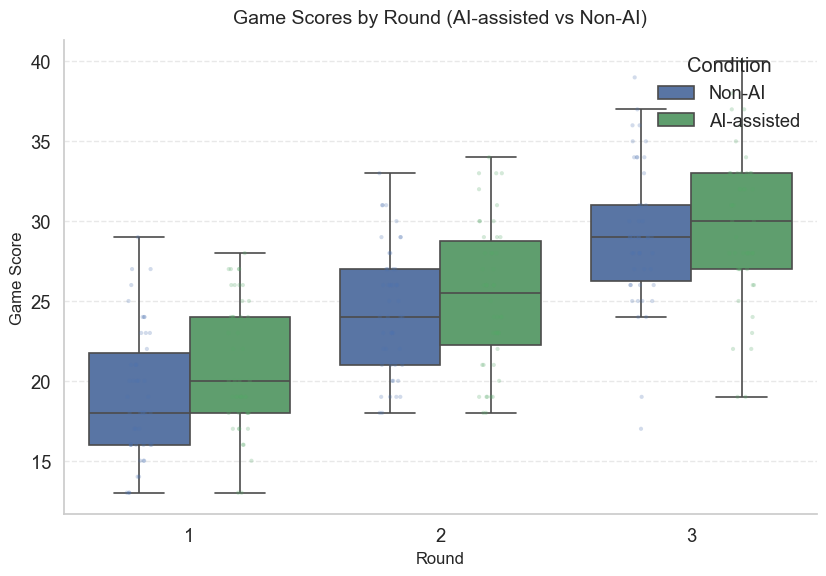

Saved boxplot to: data\game_scores_boxplot_by_round_AI.png and data\game_scores_boxplot_by_round_AI.pdf


In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Paths ----------
DATA_DIR = Path("data")  # change if needed
game_path = DATA_DIR / "whack_a_mole_game.csv"
init_path = DATA_DIR / "initial_assessment_data.csv"  # for learning_mode/condition

# ---------- Load ----------
game = pd.read_csv(game_path)
init = pd.read_csv(init_path)

# ---------- Standardize column names ----------
game.columns = [c.strip().lower() for c in game.columns]
init.columns = [c.strip().lower() for c in init.columns]

# Auto-detect participant ID column names
game_id_col = "participant_id" if "participant_id" in game.columns else "user_id"
init_id_col = "participant_id" if "participant_id" in init.columns else "user_id"

# Keep only what we need
game = game[[game_id_col, "round", "score"]].copy()
init = init[[init_id_col, "learning_mode", "round"]].drop_duplicates()

# Align ID names
game = game.rename(columns={game_id_col: "user_id"})
init = init.rename(columns={init_id_col: "user_id"})

# ---------- Map AI condition ----------
def map_ai(x: str) -> str:
    s = str(x).strip().lower()
    # Mark as AI-assisted if mode mentions llm or user-defined; adjust if your labels differ
    return "AI-assisted" if ("llm" in s or "user" in s) else "Non-AI"

init["AI Condition"] = init["learning_mode"].apply(map_ai)

# ---------- Merge AI condition into game scores ----------
df = game.merge(init[["user_id", "round", "AI Condition"]], on=["user_id", "round"], how="left")
df = df.dropna(subset=["AI Condition"]).copy()

# Order rounds
df["round"] = pd.to_numeric(df["round"], errors="coerce").astype("Int64")
df = df[df["round"].isin([1, 2, 3])]
df["round"] = pd.Categorical(df["round"], categories=[1, 2, 3], ordered=True)

# ---------- Plot: Boxplot (AI vs Non-AI by Round) ----------
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8.5, 6))

palette = ["#4C72B0", "#55A868"]  # blue, green
ax = sns.boxplot(
    data=df,
    x="round", y="score",
    hue="AI Condition",
    palette=palette,
    showcaps=True, showfliers=False, linewidth=1.2
)

# (Optional) overlay jittered points for individual scores
sns.stripplot(
    data=df,
    x="round", y="score",
    hue="AI Condition",
    palette=palette,
    dodge=True, alpha=0.25, size=3, linewidth=0
)

# Clean up duplicate legends from box+strip
handles, labels = ax.get_legend_handles_labels()
seen, H, L = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); H.append(h); L.append(l)
ax.legend(H, L, title="Condition", loc="upper right", frameon=False)

ax.set_xlabel("Round", fontsize=12)
ax.set_ylabel("Game Score", fontsize=12)
ax.set_title("Game Scores by Round (AI-assisted vs Non-AI)", fontsize=14, pad=12)
ax.grid(axis="y", linestyle="--", alpha=0.45)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
out_png = DATA_DIR / "game_scores_boxplot_by_round_AI.png"
out_pdf = DATA_DIR / "game_scores_boxplot_by_round_AI.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Saved boxplot to:", out_png, "and", out_pdf)


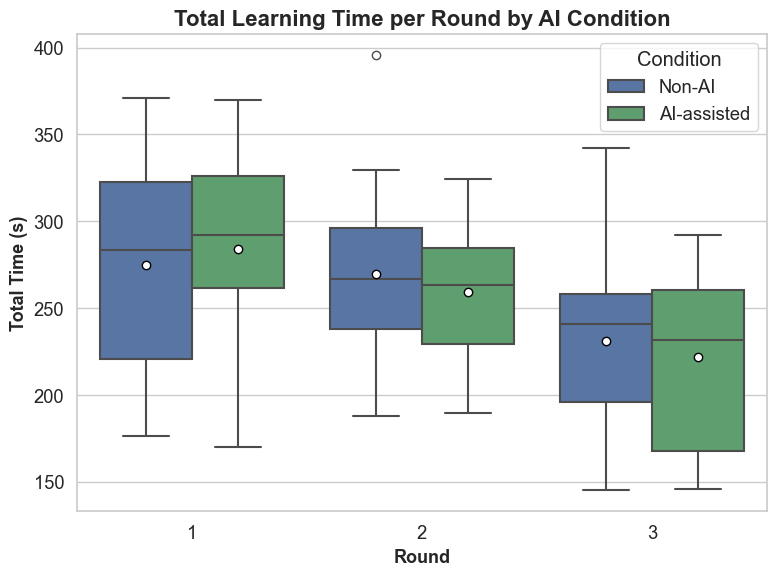


=== Independent t-test for overall total time ===
T-test: t = -0.250, p = 0.8034

=== Mixed-effects model ===


SyntaxError: invalid syntax (<unknown>, line 1)

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf

# ===== Load data =====
learning_df = pd.read_csv('data/learning_session_data.csv')

# Identify per-item time columns
time_cols = [col for col in learning_df.columns if col.endswith('_time') and col not in ['Round', 'learning_mode', 'user_id']]

# Calculate total time per user per session
learning_df['total_time'] = learning_df[time_cols].sum(axis=1)

# Map AI condition
def map_ai(x):
    s = str(x).strip().lower()
    if "llm" in s or "ai" in s:
        return "AI-assisted"
    else:
        return "Non-AI"

learning_df["AI Condition"] = learning_df["learning_mode"].apply(map_ai)

# ===== Boxplot =====
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"Non-AI": "#4C72B0", "AI-assisted": "#55A868"}

plt.figure(figsize=(8, 6))
sns.boxplot(
    x="Round", y="total_time", hue="AI Condition",
    data=learning_df, palette=palette, linewidth=1.5, showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
)
plt.title("Total Learning Time per Round by AI Condition", fontsize=16, weight="bold")
plt.xlabel("Round", fontsize=13, weight="bold")
plt.ylabel("Total Time (s)", fontsize=13, weight="bold")
plt.legend(title="Condition", loc="upper right")
plt.tight_layout()
plt.savefig("learning_time_boxplot.pdf", dpi=300)
plt.show()


In [71]:
# Rename column for modeling
learning_df = learning_df.rename(columns={"AI Condition": "AI_Condition"})

# Independent t-test
print("\n=== Independent t-test for overall total time ===")
total_times = learning_df.groupby(["user_id", "AI_Condition"])["total_time"].sum().reset_index()
ai_times = total_times[total_times["AI_Condition"] == "AI-assisted"]["total_time"]
non_ai_times = total_times[total_times["AI_Condition"] == "Non-AI"]["total_time"]

t_stat, p_val = stats.ttest_ind(ai_times, non_ai_times, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.4f}")

# Mixed-effects model with random intercept for user
print("\n=== Mixed-effects model ===")
model = smf.mixedlm("total_time ~ C(AI_Condition) * C(Round)", data=learning_df, groups=learning_df["user_id"])
result = model.fit()
print(result.summary())



=== Independent t-test for overall total time ===
T-test: t = -0.250, p = 0.8034

=== Mixed-effects model ===
                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           total_time
No. Observations:           138               Method:                       REML      
No. Groups:                 46                Scale:                        574.9857  
Min. group size:            3                 Log-Likelihood:               -669.0550 
Max. group size:            3                 Converged:                    Yes       
Mean group size:            3.0                                                       
--------------------------------------------------------------------------------------
                                         Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------------
Intercept                                283

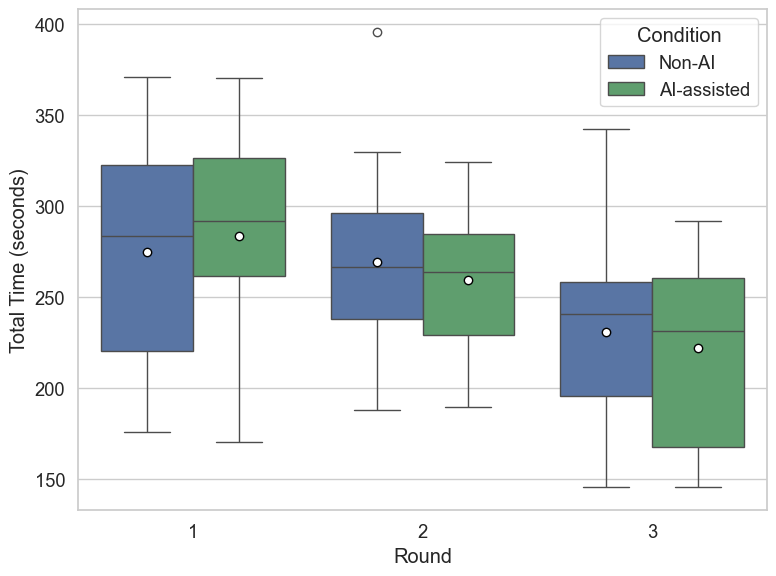


=== Two-way Mixed ANOVA results ===
                                 sum_sq    df          F        PR(>F)
C(AI_Condition)            10269.084237   1.0  17.859952  5.790535e-05
C(Round)                   68609.832354   2.0  59.662980  4.211875e-17
C(user_id)                674515.161572  45.0  26.069205  3.076400e-35
C(AI_Condition):C(Round)    2549.490441   2.0   2.217032  1.149814e-01
Residual                   50598.086672  88.0        NaN           NaN

=== Mixed-effects model results ===
                        Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           total_time
No. Observations:           138               Method:                       ML        
No. Groups:                 46                Scale:                        549.9859  
Min. group size:            3                 Log-Likelihood:               -686.5654 
Max. group size:            3                 Converged:                    Yes       
Mea

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# ========================
# 1) Load and prepare data
# ========================
df = pd.read_csv("data/learning_session_data.csv")

# Identify time columns
time_cols = [c for c in df.columns if c.endswith("_time") and c not in ["Round", "learning_mode", "user_id"]]

# Total time per user per round
df["total_time"] = df[time_cols].sum(axis=1)

# Map AI condition
def map_ai(x):
    x = str(x).lower()
    if "llm" in x:
        return "AI-assisted"
    else:
        return "Non-AI"

df["AI_Condition"] = df["learning_mode"].apply(map_ai)

# Ensure Round is numeric
df["Round"] = pd.to_numeric(df["Round"], errors="coerce").astype(int)

# ========================
# 2) Boxplot
# ========================
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="Round",
    y="total_time",
    hue="AI_Condition",
    palette={"AI-assisted": "#55A868", "Non-AI": "#4C72B0"},
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
)
# plt.title("Total Learning Time by Round and AI Condition", fontsize=16)
plt.xlabel("Round")
plt.ylabel("Total Time (seconds)")
plt.legend(title="Condition", loc="upper right")
plt.tight_layout()
plt.savefig("learning_time_boxplot.pdf", bbox_inches='tight',dpi=300)
plt.show()

# ========================
# 3) Two-way Mixed ANOVA (statsmodels OLS with subject as repeated measure)
# ========================
# For repeated measures, we need subject identifier
df_anova = df.copy()
df_anova["Round"] = df_anova["Round"].astype("category")
df_anova["AI_Condition"] = df_anova["AI_Condition"].astype("category")
df_anova["user_id"] = df_anova["user_id"].astype("category")

# OLS model (fixed effects)
model_ols = smf.ols("total_time ~ C(AI_Condition) * C(Round) + C(user_id)", data=df_anova).fit()
anova_results = anova_lm(model_ols, typ=2)
print("\n=== Two-way Mixed ANOVA results ===")
print(anova_results)

# ========================
# 4) Mixed-effects model
# ========================
model_mlm = smf.mixedlm(
    "total_time ~ C(AI_Condition) * C(Round)",
    data=df,
    groups=df["user_id"]
).fit(reml=False)

print("\n=== Mixed-effects model results ===")
print(model_mlm.summary())

# Extract key p-values
print("\n--- p-values of interest ---")
print("AI Condition main effect:", model_mlm.pvalues.get("C(AI_Condition)[T.Non-AI]", "N/A"))
print("Round × AI Condition interactions:")
for term in model_mlm.pvalues.index:
    if "C(Round)" in term and "AI_Condition" in term:
        print(f"{term}: {model_mlm.pvalues[term]}")



=== Correlation results ===
   Round AI_Condition  Pearson_r   p_value
0      1       Non-AI   0.490630  0.017454
1      1  AI-assisted  -0.081870  0.710368
2      2       Non-AI   0.243543  0.262790
3      2  AI-assisted   0.276318  0.201851
4      3       Non-AI   0.390981  0.065077
5      3  AI-assisted   0.112181  0.610323


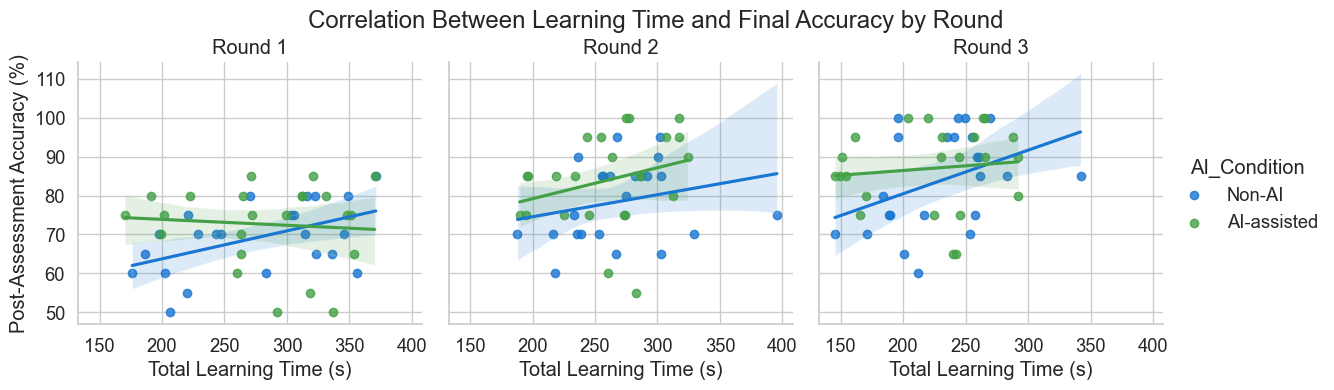

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ===== 1) Load datasets =====
learn_df = pd.read_csv("data/learning_session_data.csv")
final_df = pd.read_csv("data/final_assessment_data.csv")

# ===== 2) Compute total learning time =====
time_cols = [col for col in learn_df.columns if col.endswith('_time')]
learn_df['total_time'] = learn_df[time_cols].sum(axis=1)

# Keep relevant cols
learn_df = learn_df[['user_id', 'learning_mode', 'Round', 'total_time']]

# ===== 3) Compute final assessment accuracy =====
acc_cols = [col for col in final_df.columns if col.endswith('_correct')]
final_df['final_accuracy'] = final_df[acc_cols].mean(axis=1) * 100  # percentage

final_df = final_df[['user_id', 'learning_mode', 'Round', 'final_accuracy']]

# ===== 4) Merge =====
df = pd.merge(learn_df, final_df, on=['user_id', 'learning_mode', 'Round'], how='inner')

# ===== 5) Map AI condition =====
df['AI_Condition'] = df['learning_mode'].apply(lambda x: "AI-assisted" if "llm" in str(x).lower() else "Non-AI")

# ===== 6) Compute correlations per round & condition =====
corr_results = []
for rnd in sorted(df['Round'].unique()):
    for cond in df['AI_Condition'].unique():
        sub = df[(df['Round'] == rnd) & (df['AI_Condition'] == cond)]
        if len(sub) > 2:
            r, p = pearsonr(sub['total_time'], sub['final_accuracy'])
            corr_results.append({
                'Round': rnd,
                'AI_Condition': cond,
                'Pearson_r': r,
                'p_value': p
            })

corr_df = pd.DataFrame(corr_results)
print("\n=== Correlation results ===")
print(corr_df)

# ===== 7) Plot correlation scatterplots =====
sns.set(style="whitegrid", font_scale=1.2)
g = sns.lmplot(
    data=df,
    x="total_time", y="final_accuracy",
    col="Round", hue="AI_Condition",
    palette={"AI-assisted": "#43A047", "Non-AI": "#1976D2"},
    height=4, aspect=1
)

g.set_axis_labels("Total Learning Time (s)", "Post-Assessment Accuracy (%)")
g.set_titles("Round {col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Correlation Between Learning Time and Final Accuracy by Round")

plt.show()


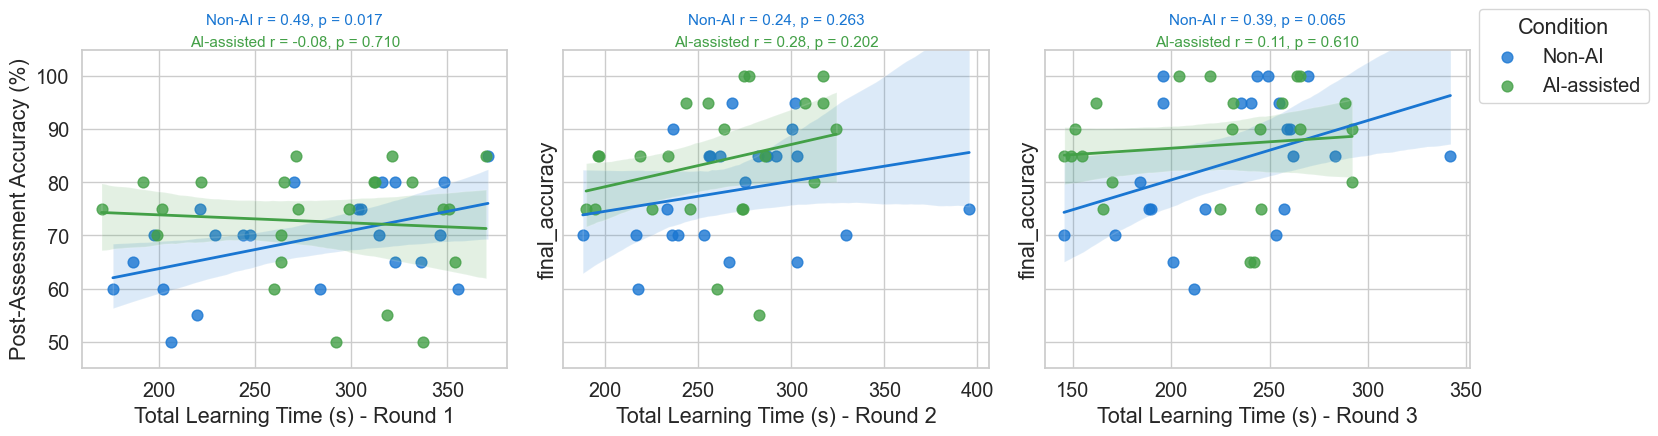

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(style="whitegrid", font_scale=1.3)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, rnd in enumerate(sorted(df['Round'].unique())):
    ax = axes[i]
    sub_df = df[df['Round'] == rnd]

    # Regression plots
    sns.regplot(
        data=sub_df[sub_df['AI_Condition'] == "Non-AI"],
        x="total_time", y="final_accuracy",
        scatter_kws={"s": 60, "alpha": 0.8},
        line_kws={"lw": 2},
        ci=95, color="#1976D2", ax=ax, label="Non-AI"
    )
    sns.regplot(
        data=sub_df[sub_df['AI_Condition'] == "AI-assisted"],
        x="total_time", y="final_accuracy",
        scatter_kws={"s": 60, "alpha": 0.8},
        line_kws={"lw": 2},
        ci=95, color="#43A047", ax=ax, label="AI-assisted"
    )

    # Compute correlations & annotate at the top
    for j, cond in enumerate(["Non-AI", "AI-assisted"]):
        cond_df = sub_df[sub_df['AI_Condition'] == cond]
        r, p = pearsonr(cond_df['total_time'], cond_df['final_accuracy'])
        ax.text(
            0.5, 1.08 - j*0.07,  # position above the plot
            f"{cond} r = {r:.2f}, p = {p:.3f}",
            transform=ax.transAxes,
            fontsize=11,
            ha='center',
            color="#1976D2" if cond == "Non-AI" else "#43A047"
        )

#     ax.set_title()
    ax.set_xlabel(f"Total Learning Time (s) - Round {rnd}")
    if i == 0:
        ax.set_ylabel("Post-Assessment Accuracy (%)")
    ax.set_ylim(45, 105)

# Place legend in the upper right of the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Condition", loc="upper right", bbox_to_anchor=(1.045, 0.9))

# fig.suptitle("Correlation Between Learning Time and Final Accuracy by Round", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 0.95, 0.93])
plt.savefig("correlation_accuracy_time.pdf", bbox_inches='tight',dpi=300)
plt.show()


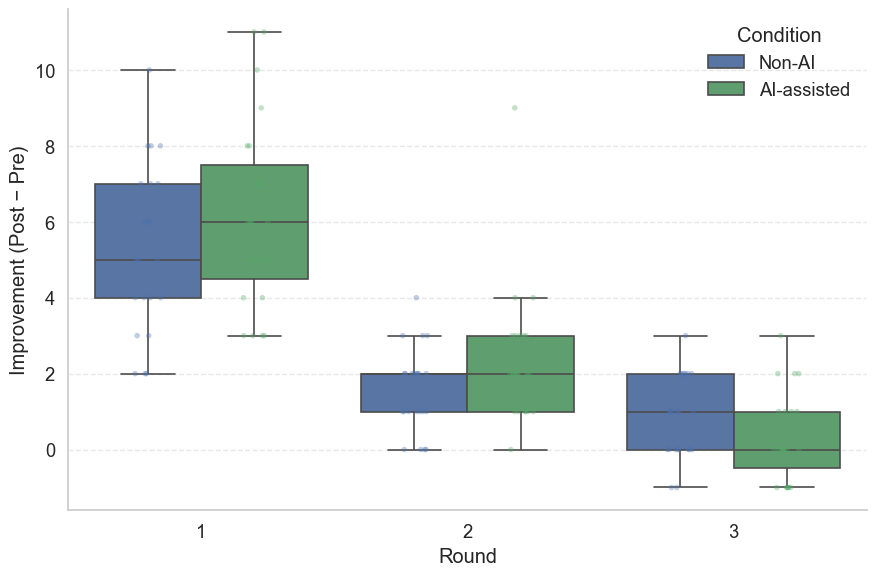

Saved figure: improvement_boxplot_by_round_AI.pdf

=== Per-round Welch t-tests (AI vs Non-AI) ===
Round 1: t = 1.397, p = 0.170 (n_AI=23, n_NonAI=23)
Round 2: t = 1.807, p = 0.079 (n_AI=23, n_NonAI=23)
Round 3: t = -1.595, p = 0.118 (n_AI=23, n_NonAI=23)

=== Two-way mixed ANOVA (Type II) ===
                              sum_sq    df           F        PR(>F)
C(AI_Condition)             8.549863   1.0    4.013822  4.820512e-02
C(Round)                  671.536232   2.0  157.629813  8.156595e-30
C(user_id)                438.515942  45.0    4.574796  5.708394e-10
C(AI_Condition):C(Round)   15.014493   2.0    3.524354  3.369798e-02
Residual                  187.449275  88.0         NaN           NaN
Saved ANOVA table: data\improvement_anova_table.csv

=== Mixed-effects model ===
                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         improvement
No. Observations:           138             Method:               

In [4]:
# ==============================
# Improvement analysis (Final - Initial)
# ==============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# ---------- Paths (edit if needed) ----------
DATA_DIR = Path("data")
PATH_REC   = DATA_DIR / "recordings.csv"
PATH_INIT  = DATA_DIR / "initial_assessment_data.csv"
PATH_FINAL = DATA_DIR / "final_assessment_data.csv"

OUT_FIG   = "improvement_boxplot_by_round_AI.pdf"
OUT_ANOVA = DATA_DIR / "improvement_anova_table.csv"
OUT_MLM   = DATA_DIR / "improvement_mixedlm.txt"

# ---------- 1) Load ----------
rec = pd.read_csv(PATH_REC)

# If "improvement" is missing, compute from initial/final files
if "improvement" not in rec.columns:
    ini = pd.read_csv(PATH_INIT)
    fin = pd.read_csv(PATH_FINAL)

    # Total scores = sum of *_correct columns
    def total_from_correct(df):
        correct_cols = [c for c in df.columns if c.endswith("_correct")]
        score = df[correct_cols].apply(pd.to_numeric, errors="coerce").fillna(0).sum(axis=1)
        out = df[["user_id","learning_mode","Round"]].copy()
        out["score"] = score
        return out

    ini_t = total_from_correct(ini).rename(columns={"score":"initial_score"})
    fin_t = total_from_correct(fin).rename(columns={"score":"final_score"})
    m = ini_t.merge(fin_t, on=["user_id","learning_mode","Round"], how="inner")
    m["improvement"] = m["final_score"] - m["initial_score"]
else:
    # Standardize key cols from recordings.csv
    rec_cols = {c.lower(): c for c in rec.columns}
    m = rec.rename(columns={
        rec_cols.get("user_id","user_id"): "user_id",
        rec_cols.get("round","Round"): "Round",
        rec_cols.get("learning_mode","learning_mode"): "learning_mode",
        rec_cols.get("improvement","improvement"): "improvement"
    })[["user_id","learning_mode","Round","improvement"]].copy()

# ---------- 2) Clean & map AI/Non-AI ----------
def map_ai(s: str) -> str:
    x = str(s).strip().lower()
    return "AI-assisted" if ("llm" in x or "user" in x) else "Non-AI"

m["AI_Condition"] = m["learning_mode"].apply(map_ai)
m["Round"] = pd.to_numeric(m["Round"], errors="coerce").astype("Int64")
m = m.dropna(subset=["user_id","Round","AI_Condition","improvement"]).copy()
m = m[m["Round"].isin([1,2,3])]
m["Round"] = pd.Categorical(m["Round"], categories=[1,2,3], ordered=True)

# ---------- 3) Figure: Boxplot (+jitter) ----------
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"Non-AI": "#4C72B0", "AI-assisted": "#55A868"}

plt.figure(figsize=(9,6))
ax = sns.boxplot(
    data=m, x="Round", y="improvement", hue="AI_Condition",
    palette=palette, showcaps=True, showfliers=False, linewidth=1.2
)
sns.stripplot(
    data=m, x="Round", y="improvement", hue="AI_Condition",
    dodge=True, alpha=0.35, size=4, linewidth=0, palette=palette
)

# De-dupe legend (box + strip)
handles, labels = ax.get_legend_handles_labels()
seen, H, L = set(), [], []
for h,l in zip(handles, labels):
    if l not in seen:
        seen.add(l); H.append(h); L.append(l)
ax.legend(H, L, title="Condition", loc="upper right", frameon=False)

ax.set_xlabel("Round")
ax.set_ylabel("Improvement (Post − Pre)")
# ax.set_title("Improvement by Round (AI-assisted vs Non-AI)")
ax.grid(axis="y", linestyle="--", alpha=0.45)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(OUT_FIG, dpi=300, bbox_inches="tight")
plt.show()
print("Saved figure:", OUT_FIG)

# ---------- 4) Per-round Welch t-tests ----------
print("\n=== Per-round Welch t-tests (AI vs Non-AI) ===")
tt_rows = []
for r in [1,2,3]:
    sub = m[m["Round"]==r]
    a = sub[sub["AI_Condition"]=="AI-assisted"]["improvement"]
    b = sub[sub["AI_Condition"]=="Non-AI"]["improvement"]
    if len(a)>=2 and len(b)>=2:
        t,p = stats.ttest_ind(a, b, equal_var=False)
        tt_rows.append({"Round": r, "t": t, "p": p, "n_AI": len(a), "n_NonAI": len(b)})
        print(f"Round {r}: t = {t:.3f}, p = {p:.3f} (n_AI={len(a)}, n_NonAI={len(b)})")
tt = pd.DataFrame(tt_rows)

# ---------- 5) Two-way mixed ANOVA (subject fixed effects via OLS) ----------
aov_df = m.copy()
aov_df["user_id"] = aov_df["user_id"].astype("category")
aov_df["AI_Condition"] = aov_df["AI_Condition"].astype("category")
aov_df["Round"] = aov_df["Round"].astype("category")

ols = smf.ols("improvement ~ C(AI_Condition) * C(Round) + C(user_id)", data=aov_df).fit()
anova_tbl = anova_lm(ols, typ=2)  # Type II SS
anova_tbl.to_csv(OUT_ANOVA)
print("\n=== Two-way mixed ANOVA (Type II) ===")
print(anova_tbl)
print("Saved ANOVA table:", OUT_ANOVA)

# ---------- 6) Mixed-effects model ----------
mlm = smf.mixedlm("improvement ~ C(AI_Condition) * C(Round)", m, groups=m["user_id"])
mlm_res = mlm.fit(reml=False)
print("\n=== Mixed-effects model ===")
print(mlm_res.summary())
with open(OUT_MLM, "w") as f:
    f.write(str(mlm_res.summary()))
print("Saved MixedLM summary:", OUT_MLM)

# ---------- 7) Auto-generate LaTeX paragraph ----------
def ptxt(p):
    if p < 0.001: return "< .001"
    return f"= {p:.3f}"

# Pull ANOVA p-values safely
p_ai  = anova_tbl.loc["C(AI_Condition)", "PR(>F)"] if "C(AI_Condition)" in anova_tbl.index else np.nan
p_rnd = anova_tbl.loc["C(Round)", "PR(>F)"] if "C(Round)" in anova_tbl.index else np.nan
p_int = anova_tbl.loc["C(AI_Condition):C(Round)", "PR(>F)"] if "C(AI_Condition):C(Round)" in anova_tbl.index else np.nan

# Descriptives (means ± SEM per round × group)
descs = (m.groupby(["Round","AI_Condition"])["improvement"]
           .agg(mean="mean", sd="std", n="count")
           .assign(sem=lambda d: d["sd"]/np.sqrt(d["n"])))

def dline(r, cond):
    row = descs.loc[(r,cond)]
    return f"{cond}, Round {r}: $M={row['mean']:.2f}$, $SEM={row['sem']:.2f}$ (n={int(row['n'])})"

# latex_text = rf"""
# \subsubsection{{Improvement Across Rounds}}
# Figure~\ref{{fig:improvement_boxplot}} displays the distribution of improvement (Final $-$ Initial) across rounds by AI condition. 
# Across both groups, improvement was largest in early rounds and diminished over time, consistent with a leveling-off of gains. 
# A two-way mixed ANOVA with \emph{{AI Condition}} (between) and \emph{{Round}} (within) showed a main effect of \emph{{Round}} ($p {ptxt(p_rnd)}$), 
# {('a main effect of \\emph{AI Condition} ($p ' + ptxt(p_ai) + '$), ' if pd.notna(p_ai) else '')}
# and {('a non-significant ' if p_int>=0.05 else 'a significant ')}\emph{{AI Condition}} $\times$ \emph{{Round}} interaction ($p {ptxt(p_int)}$).
# A mixed-effects model with random intercepts for participants reached similar conclusions (see Table~X).

# Descriptive means (±SEM) were:
# {dline(1,'AI-assisted')}; {dline(1,'Non-AI')};
# {dline(2,'AI-assisted')}; {dline(2,'Non-AI')};
# {dline(3,'AI-assisted')}; {dline(3,'Non-AI')}.
# """

# print("\n\n--- LaTeX paragraph (copy into your paper) ---\n")
# print(latex_text)
